In [32]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time


import matplotlib.pyplot as plt
import seaborn as sns

## Table of contents 

1. [About Data](#cell1)
2. [Check null](#cell2)
3. [Target -> classification](#cell3)
4. [Train | Test](#cell4)
5. [PCA](#cell5)
6. [Scaler](#cell6)
7. [Return Dataframe](#cell7)
8. [Models](#cell8)
9. [Conclusions](#cell9)

<a id="cell1"></a>
### 1. About Data

In [39]:
df = pd.read_csv('data/slice_localization_data.csv', sep=',')
df.head()


,patientId,value0,value1,value2,value3,value4,value5,value6,value7,value8,...,value375,value376,value377,value378,value379,value380,value381,value382,value383,reference
0,0,0.0,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,-0.25,...,-0.25,0.980381,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,21.803851
1,0,0.0,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,-0.25,...,-0.25,0.977008,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,21.745726
2,0,0.0,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,-0.25,...,-0.25,0.977008,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,21.687600
3,0,0.0,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,-0.25,...,-0.25,0.977008,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,21.629474
4,0,0.0,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,-0.25,...,-0.25,0.976833,0.0,0.0,0.0,0.0,0.0,-0.25,-0.25,21.571348


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53500 entries, 0 to 53499
Columns: 386 entries, patientId to reference
dtypes: float64(385), int64(1)
memory usage: 157.6 MB


In [41]:
df.describe()['reference']

count    53500.000000
mean        47.028039
std         22.347042
min          1.738733
25%         29.891607
50%         43.987893
75%         63.735059
max         97.489115
Name: reference, dtype: float64

<a id="cell2"></a>
### 2. Check null

In [23]:
# check nulls
df.isnull().sum().sum()

0

<a id="cell3"></a> 
### 3. Target -> classification

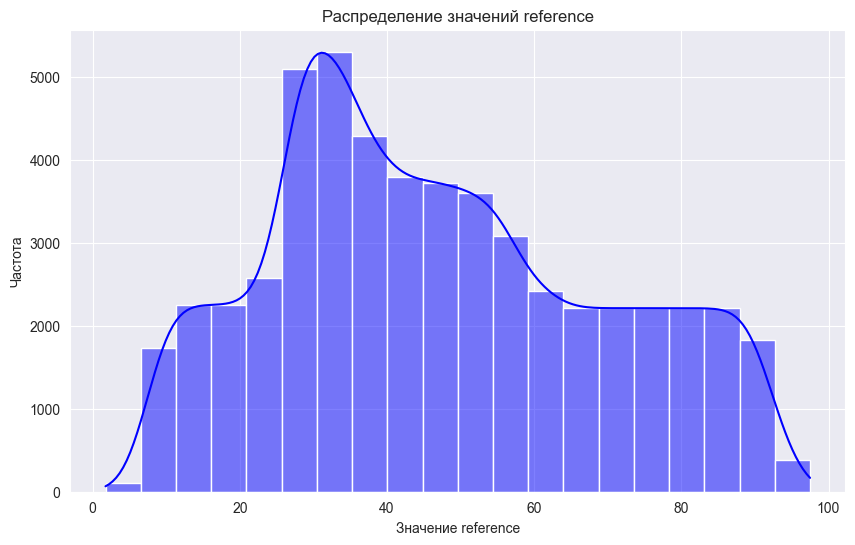

In [24]:
target = df['reference']

# Визуализация распределения значений reference
plt.figure(figsize=(10, 6))
sns.histplot(target, kde=True, bins=20, color='blue')
plt.title('Распределение значений reference')
plt.xlabel('Значение reference')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

In [25]:
# Определение границ на основе процентного распределения
explained_variance_ratio = {
    "leg": 0.35,
    "pelvis": 0.10,
    "abdomen": 0.20,
    "chest": 0.25,
    "neck": 0.05,
    "head": 0.05
}

# Вычисление границ
total_range = target.max() - target.min()  # 180 - 0
boundaries = [0]
cumulative_percentage = 0

for part, percentage in explained_variance_ratio.items():
    cumulative_percentage += percentage
    boundary = cumulative_percentage * total_range
    boundaries.append(boundary)

boundaries[-1] = target.max()
# Преобразование целевой переменной в классы
target_classes = pd.cut(target, bins=boundaries, labels=list(explained_variance_ratio.keys()), include_lowest=True)

<a id="cell4"></a> 
### 4. Train | Test

In [26]:
data_features = df.iloc[:, 1:-1]

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(data_features, target_classes, test_size=0.2, random_state=42)

<a id="cell5"></a> 
### 5. PCA

In [27]:
# Разделение признаков на структуры костей и воздушные включения для обучающей выборки
X_train_bone = X_train.iloc[:, 0:241]
X_train_air = X_train.iloc[:, 242:384]

pca_bone = PCA(n_components=6)
pca_air = PCA(n_components=6)

X_train_bone_pca = pca_bone.fit_transform(X_train_bone)
X_train_air_pca = pca_air.fit_transform(X_train_air)

# Применение PCA к тестовой выборке
X_test_bone = X_test.iloc[:, 0:241]
X_test_air = X_test.iloc[:, 242:384]

X_test_bone_pca = pca_bone.transform(X_test_bone)
X_test_air_pca = pca_air.transform(X_test_air)

<a id="cell6"></a> 
### 6. Scaler

In [28]:
# Масштабирование данных после PCA
scaler_after_pca = StandardScaler()

X_train_pca_combined = np.hstack((X_train_bone_pca, X_train_air_pca))
X_test_pca_combined = np.hstack((X_test_bone_pca, X_test_air_pca))

X_train_pca_scaled = scaler_after_pca.fit_transform(X_train_pca_combined)
X_test_pca_scaled = scaler_after_pca.transform(X_test_pca_combined)

<a id="cell7"></a> 
### 7. Return Dataframe 

In [29]:
# Преобразование обратно в DataFrame (опционально)
X_train_pca_df = pd.DataFrame(X_train_pca_scaled, columns=[f'pca_bone_feature_{i+1}' for i in range(6)] + [f'pca_air_feature_{i+1}' for i in range(6)])
X_test_pca_df = pd.DataFrame(X_test_pca_scaled, columns=[f'pca_bone_feature_{i+1}' for i in range(6)] + [f'pca_air_feature_{i+1}' for i in range(6)])

<a id="cell8"></a> 
### 8. Models

In [30]:
def encode_labels(y):
    le = LabelEncoder()
    return le.fit_transform(y)

In [33]:
# SVM

y_train_encoded = encode_labels(y_train)
y_test_encoded = encode_labels(y_test)

# Создание модели SVM
svm_model = SVC()

# Замер времени обучения
start_time = time.time()

# Обучение модели
svm_model.fit(X_train, y_train_encoded)

# Завершение замера времени
end_time = time.time()
training_time = end_time - start_time

# Оценка модели на тестовой выборке
y_pred = svm_model.predict(X_test)
# Вычисление метрик
test_accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')
f1 = f1_score(y_test_encoded, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

print(f"SVM Training Time: {training_time:.2f} seconds")
print(f"SVM Test Accuracy: {test_accuracy:.4f}")
print(f"SVM Precision: {precision:.4f}")
print(f"SVM Recall: {recall:.4f}")
print(f"SVM F1-Score: {f1:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

SVM Training Time: 37.03 seconds
SVM Test Accuracy: 0.9843
SVM Precision: 0.9845
SVM Recall: 0.9843
SVM F1-Score: 0.9843
Confusion Matrix:
[[2633   14    0    0    0   22]
 [  25 2154    0    0   23    0]
 [   0    0  157    0   15    0]
 [   0    0    0 3456    0   23]
 [   0    6    2    0  439    0]
 [  19    0    0   19    0 1693]]


In [35]:
# Создание модели Random Forest
rf_model = RandomForestClassifier()

# Замер времени обучения
start_time = time.time()

# Обучение модели
rf_model.fit(X_train, y_train_encoded)

# Завершение замера времени
end_time = time.time()
training_time = end_time - start_time

# Оценка модели на тестовой выборке
y_pred = rf_model.predict(X_test)

# Вычисление метрик
test_accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')
f1 = f1_score(y_test_encoded, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

print(f"Random Forest Training Time: {training_time:.2f} seconds")
print(f"Random Forest Test Accuracy: {test_accuracy:.4f}")
print(f"Random Forest Precision: {precision:.4f}")
print(f"Random Forest Recall: {recall:.4f}")
print(f"Random Forest F1-Score: {f1:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

Random Forest Training Time: 20.72 seconds
Random Forest Test Accuracy: 0.9925
Random Forest Precision: 0.9925
Random Forest Recall: 0.9925
Random Forest F1-Score: 0.9925
Confusion Matrix:
[[2649    7    0    0    0   13]
 [   6 2186    0    0   10    0]
 [   0    0  166    0    6    0]
 [   0    0    0 3468    0   11]
 [   0    6    3    0  438    0]
 [  11    0    0    7    0 1713]]


In [36]:
# Создание модели Logistic Regression
lr_model = LogisticRegression(max_iter=10000)

# Замер времени обучения
start_time = time.time()

# Обучение модели
lr_model.fit(X_train, y_train_encoded)

# Завершение замера времени
end_time = time.time()
training_time = end_time - start_time

# Оценка модели на тестовой выборке
y_pred = lr_model.predict(X_test)

# Вычисление метрик
test_accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')
f1 = f1_score(y_test_encoded, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

print(f"Logistic Regression Training Time: {training_time:.2f} seconds")
print(f"Logistic Regression Test Accuracy: {test_accuracy:.4f}")
print(f"Logistic Regression Precision: {precision:.4f}")
print(f"Logistic Regression Recall: {recall:.4f}")
print(f"Logistic Regression F1-Score: {f1:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

Logistic Regression Training Time: 7.45 seconds
Logistic Regression Test Accuracy: 0.9684
Logistic Regression Precision: 0.9686
Logistic Regression Recall: 0.9684
Logistic Regression F1-Score: 0.9685
Confusion Matrix:
[[2586   40    0    1    0   42]
 [  51 2123    0    5   23    0]
 [   0    0  163    0    9    0]
 [   1   14    0 3400    1   63]
 [   0   10    3    1  433    0]
 [  36    0    0   38    0 1657]]


<a id="cell9"></a> 
### 9. Выводы

Лучшей моделью является Random Forest, так как она демонстрирует наивысшую точность, наилучшие метрики (Precision, Recall, F1-Score) и наименьшее количество ошибок в матрице ошибок.

SVM также показал отличные результаты и может быть использован в случаях, когда требуется высокая точность, а время обучения не является критичным фактором.

Логистическая регрессия является самым быстрым методом обучения и может быть полезна для быстрых итераций и базового уровня точности.